# Prep for meeting with Joe and Emma


**Authorship:**
Adam Klie, *11/17/2021*
***
**Description:**
Notebook to put together figs for meeting with Joe and Emma on 11/18/2021
***
**TODOs:**
 - <font color='Red'> Meet with Joe to get a better sense of what to include and what to ignore </font>
 - <font color='Red'> Go through and clean up each slide that we decided on including </font>
  - <font color='Red'> Update self with relevant background needed to explain gkmtrain, gkmexplain </font>
***

# Set-up

In [404]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import pickle
import tqdm

# For stats
from scipy import stats

# For ml
from sklearn.metrics import confusion_matrix
import vizsequence
from vizsequence import viz_sequence

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

# Local Paths
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# Plotting params
import matplotlib as mpl
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

In [405]:
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

# Load Model Predictions

In [575]:
# Define params for dataset loading
DATASET = "2021-OLS-Library"
ACTIVE_LOW = 0.09  # The activity below which to define inactive enhancers
ACTIVE_HIGH = 0.4  # The activity above which to define active enhancers
PREPROCESS = "{}-{}".format(ACTIVE_LOW, ACTIVE_HIGH)  # String defining the preprocessing for saving
FEATURES = "fasta"  # What features to use to train the model
LABELS = "binary"
HYPERPARAM = "final-selected"
MODEL = "gkSVM"
OUTDIR = "../gkSVM/Result_{0}_{1}_gkSVM-clf_{2}".format(PREPROCESS, FEATURES, HYPERPARAM)

## 2021 OLS Library Training and Validation Set Predictions

In [576]:
# Load in dataframe
dataframe = pd.read_csv("../data/{0}/20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv".format(DATASET.replace("-", "_")), sep="\t", na_values="na")
dataframe = dataframe.set_index("NAME")

# Add labels based on decided cutoffs of activity
dataframe["labels"] = np.nan
dataframe.loc[dataframe["ACTIVITY_SUMRNA_NUMDNA"] <= ACTIVE_LOW, "labels"] = 0
dataframe.loc[dataframe["ACTIVITY_SUMRNA_NUMDNA"] >= ACTIVE_HIGH, "labels"] = 1

# Set-up file paths
pos_tr_file = os.path.join(OUTDIR, "{0}_{1}_gkSVM-clf_{2}.tr.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))
neg_tr_file = os.path.join(OUTDIR, "{0}_{1}_gkSVM-clf_{2}.neg.tr.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))
pos_file = os.path.join(OUTDIR, "{0}_{1}_gkSVM-clf_{2}.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))
neg_file = os.path.join(OUTDIR, "{0}_{1}_gkSVM-clf_{2}.neg.predict.txt".format(PREPROCESS, FEATURES, HYPERPARAM))

# Load probabilities
pos_tr_scores = pd.read_csv(pos_tr_file, delim_whitespace=True, header=None, names=["PREPROCESS", "gkSVM_score"])
neg_tr_scores = pd.read_csv(neg_tr_file, delim_whitespace=True, header=None, names=["NAME", "gkSVM_score"])
pos_scores = pd.read_csv(pos_file, delim_whitespace=True, header=None, names=["NAME", "gkSVM_score"])
neg_scores = pd.read_csv(neg_file, delim_whitespace=True, header=None, names=["NAME", "gkSVM_score"])

# Add labels
pos_scores["gkSVM_labels"] = 1
pos_tr_scores["gkSVM_labels"] = 1
neg_scores["gkSVM_labels"] = 0
neg_tr_scores["gkSVM_labels"] = 0

# Add preds
pos_scores["gkSVM_preds"] = (pos_scores["gkSVM_score"] >= 0).astype(int)
pos_tr_scores["gkSVM_preds"] = (pos_tr_scores["gkSVM_score"] >= 0).astype(int)
neg_scores["gkSVM_preds"] = (neg_scores["gkSVM_score"] >= 0).astype(int)
neg_tr_scores["gkSVM_preds"] = (neg_tr_scores["gkSVM_score"] >= 0).astype(int)

# Merge
clf_train_df = pd.concat([pos_tr_scores, neg_tr_scores]).set_index("NAME")
clf_val_df = pd.concat([pos_scores, neg_scores]).set_index("NAME")
print(len(pos_tr_scores), len(neg_tr_scores), len(pos_scores), len(neg_scores))

# Make train df
train_df = pd.merge(dataframe, clf_train_df, left_index=True, right_index=True)
train_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in train_df[["labels", "{}_preds".format(MODEL)]].values.astype(str)]
train_df["{}_classification".format(MODEL)] = train_df["{}_classification".format(MODEL)].replace({"0.0-0.0": "TN", "1.0-0.0": "FN", "0.0-1.0": "FP", "1.0-1.0": "TP"})
train_df["{}_classification".format(MODEL)].value_counts()

# Make test df
val_df = pd.merge(dataframe, clf_val_df, left_index=True, right_index=True)
val_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in val_df[["labels", "{}_preds".format(MODEL)]].values.astype(str)]
val_df["{}_classification".format(MODEL)] = val_df["{}_classification".format(MODEL)].replace({"0.0-0.0": "TN", "1.0-0.0": "FN", "0.0-1.0": "FP", "1.0-1.0": "TP"})
val_df["{}_classification".format(MODEL)].value_counts()

84829 92964 9360 10395


TN    7172
TP    6965
FP    3223
FN    2395
Name: gkSVM_classification, dtype: int64

## 2021 OLS Library Microscope (Test 1) and Ambiguous Seqs (Test* 2)
\*No labels

In [577]:
# Load in held-out scores
held_out_scores = pd.read_csv(os.path.join(OUTDIR, "{0}_X-hold-out_fasta.fa.predict.txt".format(PREPROCESS)), delim_whitespace=True, header=None, names=["NAME", "gkSVM_score"])
held_out_scores["gkSVM_preds"] = (held_out_scores["gkSVM_score"] >= 0).astype(int)
held_out_scores = held_out_scores.set_index("NAME")
held_out_df = pd.merge(dataframe, held_out_scores, left_index=True, right_index=True)
held_out_df["MICROSCOPE_FXN"].value_counts()

Neural Enhancer                35
Non-Functional                 26
Weak Neural Enhancer           14
Neural + Ectopic Expression     3
Name: MICROSCOPE_FXN, dtype: int64

In [578]:
len(held_out_scores)

263252

## 2010 Khoueiry (Test Set 3)

In [579]:
# Load dataframe with sequence information
test1_dataset = pd.read_csv("../data/2010_Khoueiry_CellPress/2010_Khoueiry_tiled.tsv", sep="\t")

In [580]:
test1_dataset = test1_dataset.set_index(["Name", "Type"])

In [581]:
#test1_dataset = pd.read_excel("../data/2010_Khoueiry_CellPress/1-s2.0-S096098221000432X-mmc2.xls", sheet_name="Table S2", skiprows=2)
test1_dataset = test1_dataset[~test1_dataset["Enhancer Activity"].isna()]

KeyError: 'Enhancer Activity'

In [582]:
# Clean up sequence by removing constant regions and clean up labels by equating 'none' to inaxctive
test1_dataset["Sequence"] = test1_dataset["Cloned and Tested C. i. Sequence"].apply(lambda x: x.replace("ACCCAACTTT", ""))
test1_dataset["Sequence"] = test1_dataset["Sequence"].apply(lambda x: x.replace("AAAGTAGGCT", ""))
test1_dataset["label"] = (test1_dataset["Enhancer Activity"] != "none").astype(int)
test1_dataset["NAME"] = test1_dataset.apply(lambda x: ":".join(x[["Position", "Start", "End"]].astype(str)), axis=1).values
test1_dataset = test1_dataset.set_index("NAME")
test1_dataset["Sequence_len"] = test1_dataset["Sequence"].apply(len)

KeyError: 'Cloned and Tested C. i. Sequence'

In [ ]:
test1_scores

In [584]:
# Load scores
test1_score_file = os.path.join(OUTDIR, "2010_Khoueiry_CellPress_tiled.predict.txt")
test1_scores = pd.read_csv(test1_score_file, delim_whitespace=True, header=None, names=["NAME", "gkSVM_score"])
test1_scores[["NAME", "Type"]] = [[":".join(score[:-1]), score[-1]] for score in test1_scores["NAME"].str.split(":").tolist()]
test1_scores = test1_scores.set_index(["NAME", "Type"])

# Add preds
test1_scores["gkSVM_preds"] = (test1_scores["gkSVM_score"] >= 0).astype(int)

# Make df
test1_df = pd.concat([test1_dataset, test1_scores], axis=1)
test1_df["sequence_len"] = test1_df["Sequence"].apply(len)
test1_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in test1_df[["label", "{}_preds".format(MODEL)]].values.astype(str)]
test1_df["{}_classification".format(MODEL)] = test1_df["{}_classification".format(MODEL)].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test1_df = test1_df.reset_index()
test1_df["{}_classification".format(MODEL)].value_counts()

FP    720
TP    500
TN    221
FN    156
Name: gkSVM_classification, dtype: int64

In [583]:
# Load the actual test1 scores
test1_score_file = os.path.join(OUTDIR, "2010_Khoueiry_CellPress.predict.txt")
test1_scores = pd.read_csv(test1_score_file, delim_whitespace=True, header=None, names=["NAME", "gkSVM_score"])
test1_scores["gkSVM_preds"] = (test1_scores["gkSVM_score"] >= 0).astype(int)
test1_scores = test1_scores.set_index("NAME")
test1_df = pd.merge(test1_dataset, test1_scores, left_index=True, right_index=True)
test1_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in test1_df[["label", "{}_preds".format(MODEL)]].values.astype(str)]
test1_df["{}_classification".format(MODEL)] = test1_df["{}_classification".format(MODEL)].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test1_df["{}_classification".format(MODEL)].value_counts()

ValueError: cannot join with no overlapping index names

In [530]:
test1_df

,level_0,Type,index,Sequence,label,Sequence_len,gkSVM_score,gkSVM_preds,sequence_len,gkSVM_classification
0,Scaffold_31:173924:174038,0,726,ATACAACGCGTGTCGAATCTGAATGTTCAATTCAATAACTGACACA...,0,66,-0.604995,0,66,TN
1,Scaffold_31:173924:174038,1,727,TACAACGCGTGTCGAATCTGAATGTTCAATTCAATAACTGACACAA...,0,66,-0.604995,0,66,TN
2,Scaffold_31:173924:174038,2,728,ACAACGCGTGTCGAATCTGAATGTTCAATTCAATAACTGACACAAT...,0,66,-0.607280,0,66,TN
3,Scaffold_31:173924:174038,3,729,CAACGCGTGTCGAATCTGAATGTTCAATTCAATAACTGACACAATT...,0,66,-0.610262,0,66,TN
4,Scaffold_31:173924:174038,4,730,AACGCGTGTCGAATCTGAATGTTCAATTCAATAACTGACACAATTT...,0,66,-0.610262,0,66,TN
...,...,...,...,...,...,...,...,...,...,...
1592,scaffold_6:562995:563124,135,1002,ATCGTGCTCTTGTCCGCCGACTTCTCGCTATCACACCGTGGAGAGA...,1,66,-0.616326,0,66,FN
1593,scaffold_6:562995:563124,136,1003,TCGTGCTCTTGTCCGCCGACTTCTCGCTATCACACCGTGGAGAGAA...,1,66,-0.618575,0,66,FN
1594,scaffold_6:562995:563124,137,1004,CGTGCTCTTGTCCGCCGACTTCTCGCTATCACACCGTGGAGAGAAC...,1,66,-0.618575,0,66,FN
1595,scaffold_6:562995:563124,full,34,CCGCCTCTCCTGCTATTGTCTTGCGGAAATGGGGTCGAGGAAAAGG...,1,203,-0.613365,0,203,FN


## 2021 GATA/ETS Clusters (Test Set 4)

In [585]:
# Load dataframe
test2_dataset = pd.read_csv("../data/2021_GATA_ETS_clusters/GATA_ETS_clusters_tiled.tsv", sep="\t")
#test2_dataset = pd.read_excel("../data/2021_GATA_ETS_clusters/GATA_ETS_clusters.xlsx", sheet_name=0).dropna()
test2_dataset = test2_dataset.set_index(["Name", "Type"])

# Load scores
test2_score_file = os.path.join(OUTDIR, "2021_GATA_ETS_tiled.predict.txt")
test2_scores = pd.read_csv(test2_score_file, delim_whitespace=True, header=None, names=["NAME", "gkSVM_score"])
test2_scores[["NAME", "Type"]] = test2_scores["NAME"].str.split(":").tolist()
test2_scores = test2_scores.set_index(["NAME", "Type"])

# Add preds
test2_scores["gkSVM_preds"] = (test2_scores["gkSVM_score"] >= 0).astype(int)

# Make df
test2_df = pd.concat([test2_dataset, test2_scores], axis=1)
test2_df["sequence_len"] = test2_df["Sequence"].apply(len)
test2_df["{}_classification".format(MODEL)] = ["-".join(list(value)) for value in test2_df[["label", "{}_preds".format(MODEL)]].values.astype(str)]
test2_df["{}_classification".format(MODEL)] = test2_df["{}_classification".format(MODEL)].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test2_df = test2_df.reset_index()
test2_df["{}_classification".format(MODEL)].value_counts()

FP    98
FN    70
TN    45
TP    45
Name: gkSVM_classification, dtype: int64

# Performance Overview Across Models
 - Simple barplot of auROC and auPRC for all model "types" trained so far

# Swarm Me

In [437]:
data = held_out_df[~held_out_df["MICROSCOPE_FXN"].isna()]

In [438]:
microscope_colors = dict(zip(data["MICROSCOPE_FXN"].unique(), ["darkgreen", "lightgreen", "gold", "red"]))

Text(0.5, 0, 'MPRA Activity')

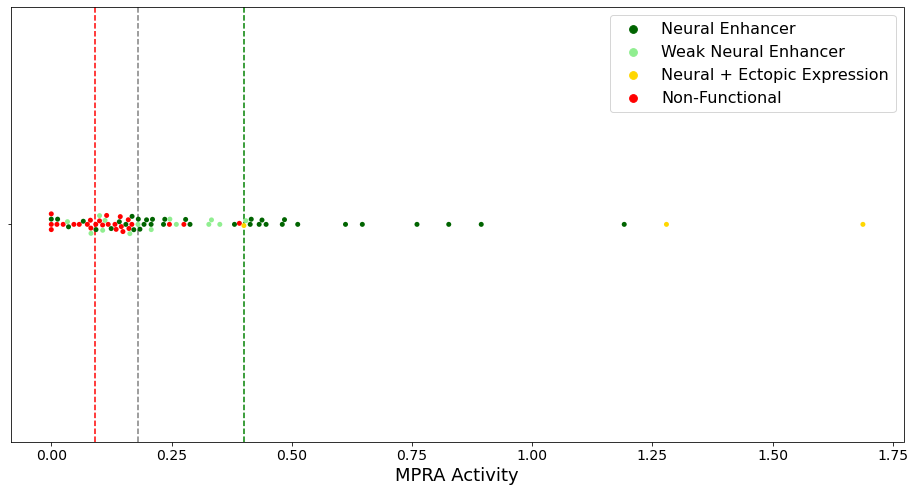

In [439]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.swarmplot(x=data["ACTIVITY_SUMRNA_NUMDNA"], y=[""]*len(data), hue=data["MICROSCOPE_FXN"], palette=microscope_colors, orient="h", ax=ax)
plt.legend(bbox_to_anchor=(1,1))
ax.vlines(0.09, ax.get_ylim()[0], ax.get_ylim()[1], color="red", linestyle="dashed")
ax.vlines(0.18, ax.get_ylim()[0], ax.get_ylim()[1], color="grey", linestyle="dashed")
ax.vlines(0.4, ax.get_ylim()[0], ax.get_ylim()[1], color="green", linestyle="dashed")
ax.set_xlabel("MPRA Activity")
#ax.annotate("N=209k", (0.5, ax.get_ylim()[0]-0.1), fontsize=16)
#ax.annotate("N=94k", (-0.075, ax.get_ylim()[0]-0.1), fontsize=16)

## Performance Barplot

In [440]:
# Clean up dataframe
performance_df = pd.read_csv("2021_11_10_performance_summary.csv")
performance_df["Model"] = ["Logistic Regression", "Random Forest", "gkSVM", "Gradient Booster", "CNN", "RNN", "Meta"]

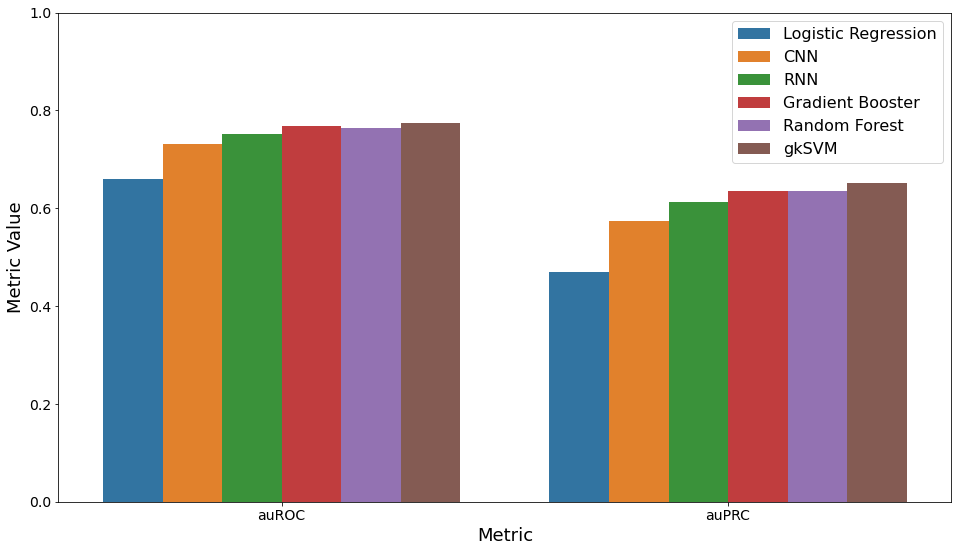

In [441]:
# Drop meta for now and plot performances
plot_df = performance_df.melt(id_vars="Model", value_vars=["auROC", "auPRC"], var_name="Metric", value_name="Metric Value")
plot_df = plot_df[~(plot_df["Model"] == "Meta")]
fig, ax = plt.subplots(1, 1, figsize=(16,9))
sns.barplot(data=plot_df.sort_values("Metric Value"), x="Metric", y="Metric Value", hue="Model", linewidth=1, order=["auROC", "auPRC"]);
ax.set_ylim(0, 1)
plt.legend(loc="upper right");

# Analysis of Validation Set Enhancers
 - Confusion matrix
 - Scatterplot of scores vs activity
 - TP, FP, FN, TN across thresholds plot

In [604]:
data = val_df
data.iloc[0]

SEQUENCE                  CATCTGAAGCTCGAGATAACTAACGGAAGTTTTCGAAAAGGAAATT...
MPRA_FXN                                                                1.0
MICROSCOPE_FXN                                                          NaN
ACTIVITY_SUMRNA_NUMDNA                                             0.468321
labels                                                                  1.0
gkSVM_score                                                         1.06407
gkSVM_labels                                                              1
gkSVM_preds                                                               1
gkSVM_classification                                                     TP
Name: S1-G1F-S2-E1F-S3-E2F-S4-G2R-S5-G3R-S6, dtype: object

## Confusion matrix

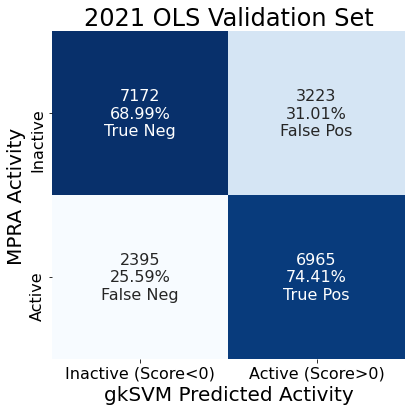

In [605]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

rc = {"font.size": 16}
with plt.rc_context(rc):
    cf_names = ["True Neg","False Pos", "False Neg","True Pos"]
    cf_mtx = confusion_matrix(data["labels"], data["gkSVM_preds"])
    cf_pcts = ["{0:.2%}".format(value) for value in (cf_mtx/cf_mtx.sum(axis=1)[:,None]).flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(cf_mtx.flatten(),cf_pcts, cf_names)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_mtx, annot=labels, fmt='s', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('gkSVM Predicted Activity', fontsize=20)
    ax.set_ylabel('MPRA Activity', fontsize=20)
    ax.set_title('2021 OLS Validation Set', fontsize=24)
    ax.set_yticklabels(["Inactive", "Active"], fontsize=16)
    ax.set_xticklabels(["Inactive (Score<0)", "Active (Score>0)"], fontsize=16)
    plt.tight_layout();

## Scatterplot with Activity 

<AxesSubplot:xlabel='ACTIVITY_SUMRNA_NUMDNA', ylabel='gkSVM_score'>

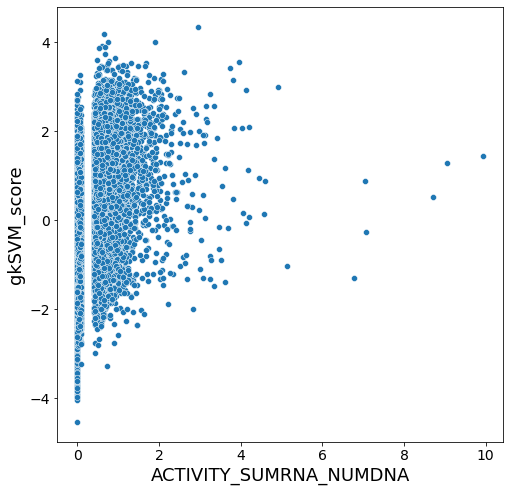

In [606]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="gkSVM_score", ax=ax)
#ax.annotate(r'Pearson $r = .442$' + '\n' + r'p $=0$', (10, 3), fontsize=16)

Text(0, 13, 'Pearson $r = .442$\np $=0$')

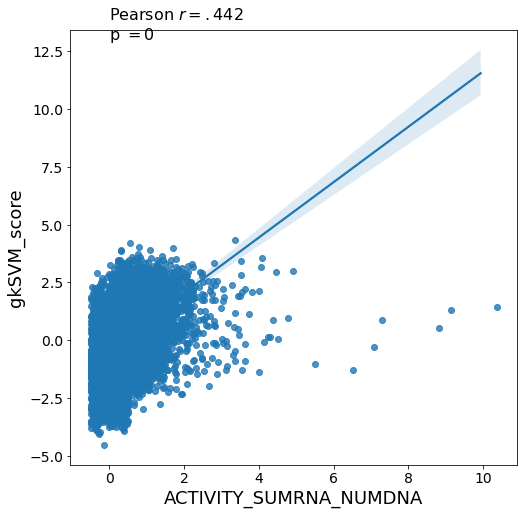

In [589]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.regplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="gkSVM_score", x_jitter=.5, ax=ax)
ax.annotate(r'Pearson $r = .442$' + '\n' + r'p $=0$', (0, 13), fontsize=16)

In [591]:
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["gkSVM_score"])

SpearmanrResult(correlation=0.5164194891195893, pvalue=0.0)

## TP, FP, FN, TN Across Thresholds

In [73]:
tns, fps, fns, tps = [], [], [], []
threshs = np.arange(data["gkSVM_score"].min(), data["gkSVM_score"].max(), 0.1)
for i, thresh in tqdm.tqdm(enumerate(threshs)):
    data["curr_pred"] = (data["gkSVM_score"] >= thresh).astype(int)
    data["curr_class"] = ["-".join(list(value)) for value in data[["labels", "curr_pred"]].values.astype(str)]
    data["curr_class"] = data["curr_class"].replace({"0.0-0.0": "TN", "1.0-0.0": "FN", "0.0-1.0": "FP", "1.0-1.0": "TP"})
    
    class_results = data["curr_class"].value_counts()
    if "TN" in class_results:
        tns.append(class_results["TN"])
    else:
        tns.append(0)
        
    if "FP" in class_results:
        fps.append(class_results["FP"])
    else:
        fps.append(0)
        
    if "FN" in class_results:
        fns.append(class_results["FN"])
    else:
        fns.append(0)
        
    if "TP" in class_results:
        tps.append(class_results["TP"])
    else:
        tps.append(0)

79it [00:07, 11.11it/s]


In [74]:
nb_negs = (data["labels"] == 0).sum()
nb_pos = (data["labels"] == 1).sum()
print(np.array([tns, fps, fns, tps]).sum(axis=0))
len(tns), len(fps), len(fns), len(tps), len(threshs)

[30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288
 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288
 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288
 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288
 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288
 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288 30288
 30288 30288 30288 30288 30288 30288 30288]


(79, 79, 79, 79, 79)

Text(0, 0.5, 'Classification Rate')

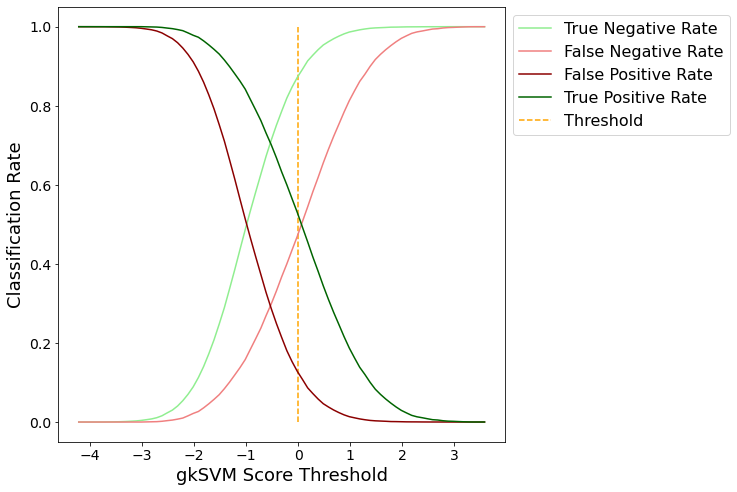

In [184]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(threshs, tns/nb_negs, color="lightgreen", label="True Negative Rate")
plt.plot(threshs, fns/nb_pos, color="lightcoral", label="False Negative Rate")
plt.plot(threshs, fps/nb_negs, color="darkred", label="False Positive Rate")
plt.plot(threshs, tps/nb_pos, color="darkgreen", label="True Positive Rate")
plt.vlines(0, 0, 1, color="orange", linestyle="dashed", label="Threshold")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("gkSVM Score Threshold")
plt.ylabel("Classification Rate")

## Interpretation

In [76]:
# Read in scores
explain_file = os.path.join(OUTDIR, "{}_X-test-0.1_fasta-neg.fa.explanations.txt".format(PREPROCESS))
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explain_file)
]

#read in the fasta files and one-hot encode
fasta_file = "../data/2021_OLS_Library/fasta/{}_X-test-0.1_fasta-neg.fa".format(PREPROCESS)
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fasta_file))
              if i%2==1]
fasta_ids = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(fasta_file))
              if i%2==0]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

In [83]:
viz_df = val_df.loc[fasta_ids].iloc[:len(impscores)]
viz_df = pd.concat([viz_df.reset_index().nlargest(3, "gkSVM_score"), viz_df.reset_index().nsmallest(3, "gkSVM_score")])

[2.85023 'FP']


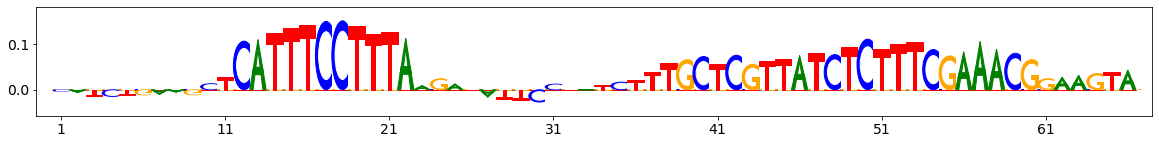

[2.68846 'FP']


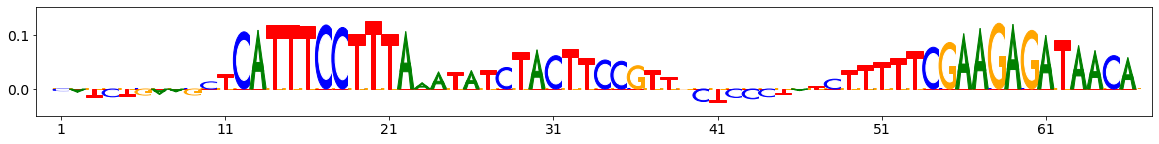

[2.48299 'FP']


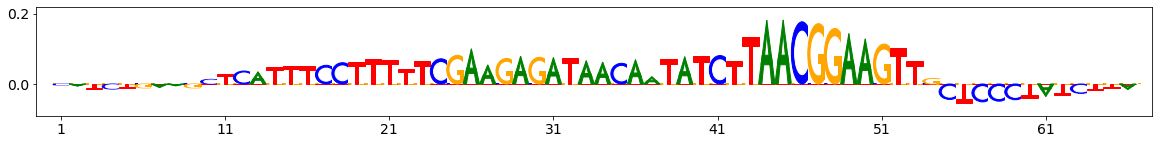

[-4.22007 'TN']


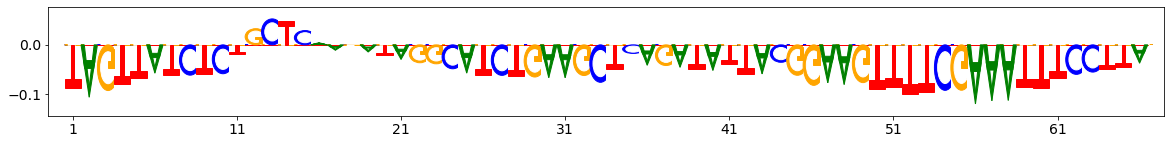

[-3.94747 'TN']


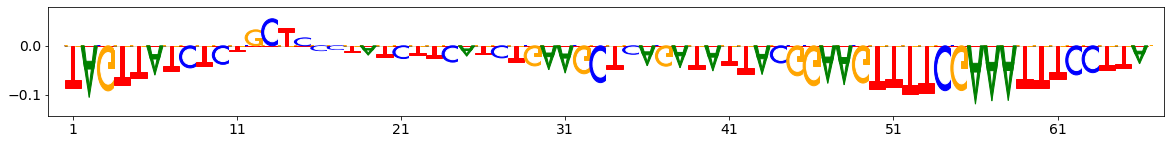

[-3.79732 'TN']


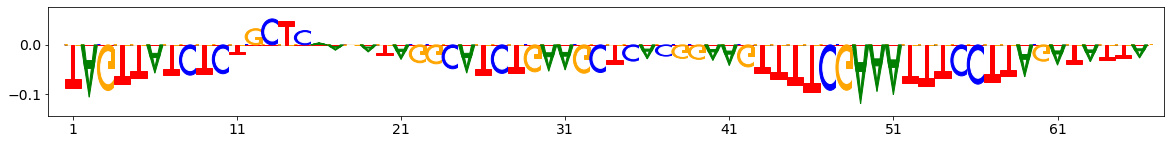

In [110]:
for i in viz_df.index:
    print(viz_df.loc[i][["gkSVM_score", "gkSVM_classification"]].values)
    viz_sequence.plot_weights(impscores[i], subticks_frequency=10)
    imp_score_each_pos = np.sum(impscores[i],axis=-1)
    imp_score_sign_each_pos = np.sign(imp_score_each_pos)

# Analysis of Enhancers Microscope Function
 - Confusion Matrix
 - Swarmplot of scores, colored by microscope function
 - Scatterplot of correlation with activity, again colored by microscope function
 - Interpretation of salient features using gkmexplain

In [445]:
sum(~microscope_mask)

263174

In [592]:
microscope_mask = (~held_out_df["MICROSCOPE_FXN"].isna())
microscope_df = held_out_df[microscope_mask]
microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)
data = microscope_df
data["microscope_label"].value_counts()

<ipython-input-592-d40b78b9b00d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  microscope_df["microscope_label"] = (~(microscope_df["MICROSCOPE_FXN"] == "Non-Functional")).astype(int)


1    52
0    26
Name: microscope_label, dtype: int64

## Confusion matrix

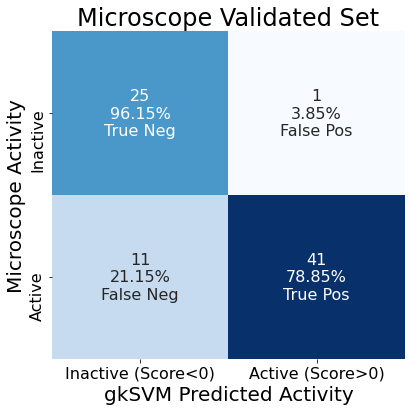

In [593]:
fig, ax = plt.subplots(1,1,figsize=(6,6))

rc = {"font.size": 16}
with plt.rc_context(rc):
    cf_names = ["True Neg","False Pos", "False Neg","True Pos"]
    cf_mtx = confusion_matrix(data["microscope_label"], data["gkSVM_preds"])
    cf_pcts = ["{0:.2%}".format(value) for value in (cf_mtx/cf_mtx.sum(axis=1)[:,None]).flatten()]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(cf_mtx.flatten(),cf_pcts, cf_names)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_mtx, annot=labels, fmt='s', cmap='Blues', cbar=False, ax=ax)
    ax.set_xlabel('gkSVM Predicted Activity', fontsize=20)
    ax.set_ylabel('Microscope Activity', fontsize=20)
    ax.set_title('Microscope Validated Set', fontsize=24)
    ax.set_yticklabels(["Inactive", "Active"], fontsize=16)
    ax.set_xticklabels(["Inactive (Score<0)", "Active (Score>0)"], fontsize=16)
    plt.tight_layout();

In [594]:
microscope_order = ['Non-Functional', 'Weak Neural Enhancer', 'Neural Enhancer', 'Neural + Ectopic Expression']

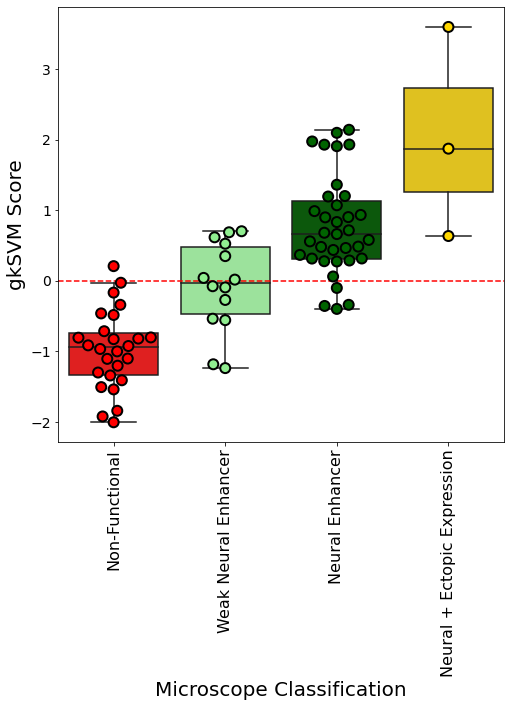

In [595]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.boxplot(y=data["gkSVM_score"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, ax=ax)
sns.swarmplot(y=data["gkSVM_score"], x=data["MICROSCOPE_FXN"], order=microscope_order, palette=microscope_colors, size=10, edgecolor="black", linewidth=2, ax=ax)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed")
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=16);
ax.set_xlabel("Microscope Classification", fontsize=20)
ax.set_ylabel("gkSVM Score", fontsize=20);

## Swarmplot of gkSVM Scores

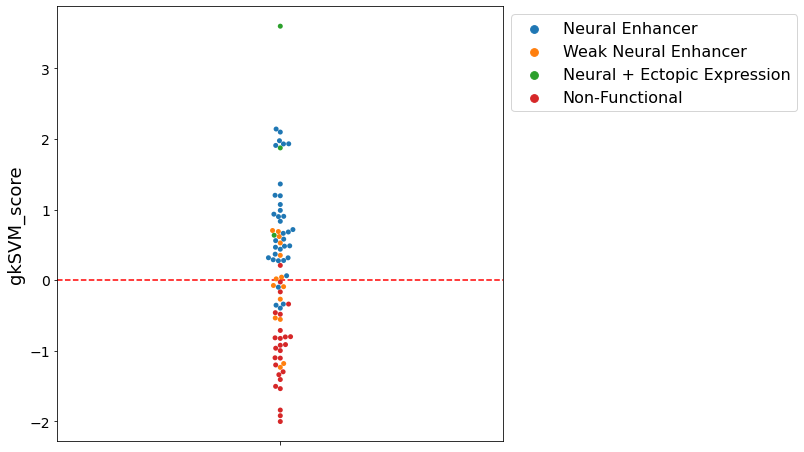

In [596]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
sns.swarmplot(y=data["gkSVM_score"], hue=data["MICROSCOPE_FXN"], x=[""]*len(data), ax=ax)
plt.legend(bbox_to_anchor=(1,1))
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");

## Scatterplot with Activity 

In [597]:
m, b = np.polyfit(data["ACTIVITY_SUMRNA_NUMDNA"], data["gkSVM_score"], 1)

0.5072716705894401 2.1399269954232838e-06


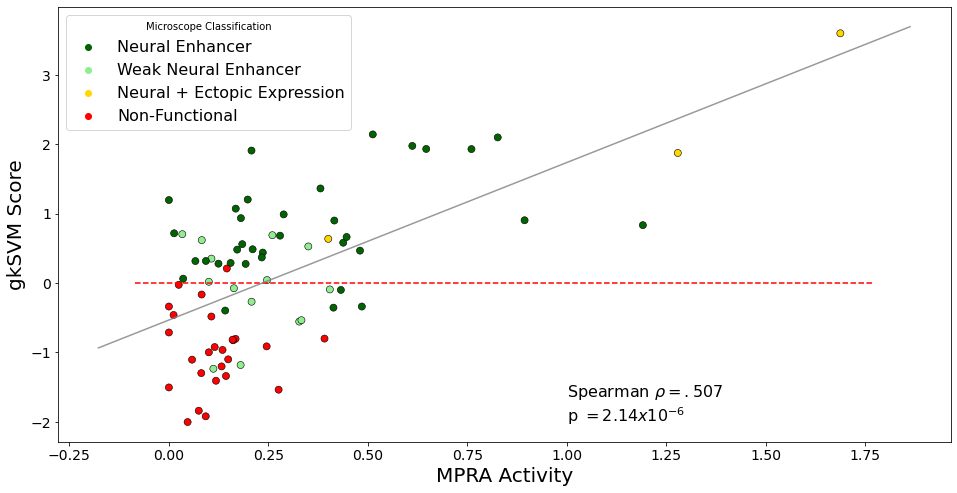

In [598]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=data, x="ACTIVITY_SUMRNA_NUMDNA", y="gkSVM_score", hue="MICROSCOPE_FXN", palette=microscope_colors, s=50, edgecolor="black", ax=ax)
ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color="red", linestyle="dashed");
ax.set_xlabel("MPRA Activity", fontsize=20)
ax.set_ylabel("gkSVM Score", fontsize=20);
ax.legend(title='Microscope Classification', fontsize=16)

# Add trendline
x=np.arange(ax.get_xlim()[0], ax.get_xlim()[1], 0.01)
ax.plot(x, m*x + b, '-', color = "grey", alpha=0.8)

# Add pearson
no_na = (~data["ACTIVITY_SUMRNA_NUMDNA"].isna())
r, p = stats.spearmanr(data[no_na]["ACTIVITY_SUMRNA_NUMDNA"], data[no_na]["gkSVM_score"])
print(r, p)
ax.annotate(r'Spearman $\rho = .507$' + '\n' + r'p $=2.14x10^{-6}$', (1, -2), fontsize=16);

## TP, FP, FN, TN Across Thresholds

In [216]:
tns, fps, fns, tps = [], [], [], []
threshs = np.arange(data["gkSVM_score"].min(), data["gkSVM_score"].max(), 0.1)
for i, thresh in tqdm.tqdm(enumerate(threshs)):
    data["curr_pred"] = (data["gkSVM_score"] >= thresh).astype(int)
    data["curr_class"] = ["-".join(list(value)) for value in data[["labels", "curr_pred"]].values.astype(str)]
    data["curr_class"] = data["curr_class"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
    
    class_results = data["curr_class"].value_counts()
    if "TN" in class_results:
        tns.append(class_results["TN"])
    else:
        tns.append(0)
        
    if "FP" in class_results:
        fps.append(class_results["FP"])
    else:
        fps.append(0)
        
    if "FN" in class_results:
        fns.append(class_results["FN"])
    else:
        fns.append(0)
        
    if "TP" in class_results:
        tps.append(class_results["TP"])
    else:
        tps.append(0)

0it [00:00, ?it/s]<ipython-input-216-70a52a15e89e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["curr_pred"] = (data["gkSVM_score"] >= thresh).astype(int)
<ipython-input-216-70a52a15e89e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["curr_class"] = ["-".join(list(value)) for value in data[["labels", "curr_pred"]].values.astype(str)]
<ipython-input-216-70a52a15e89e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_

In [219]:
nb_negs = (data["labels"] == 0).sum()
nb_pos = (data["labels"] == 1).sum()
print(np.array([tns, fps, fns, tps]).sum(axis=0))
len(tns), len(fps), len(fns), len(tps), len(threshs)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


(57, 57, 57, 57, 57)

Text(0, 0.5, 'Classification Rate')

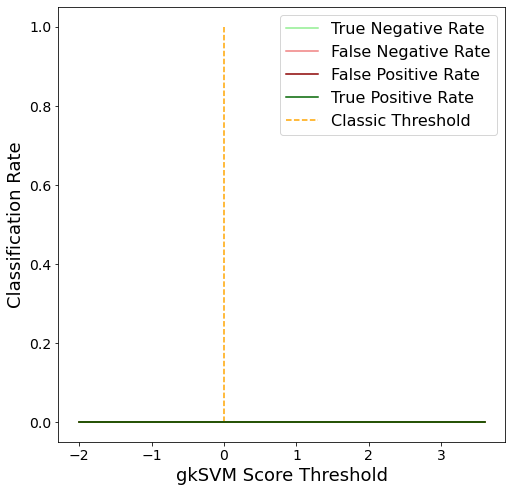

In [220]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(threshs, tns/nb_negs, color="lightgreen", label="True Negative Rate")
plt.plot(threshs, fns/nb_pos, color="lightcoral", label="False Negative Rate")
plt.plot(threshs, fps/nb_negs, color="darkred", label="False Positive Rate")
plt.plot(threshs, tps/nb_pos, color="darkgreen", label="True Positive Rate")
plt.vlines(0, 0, 1, color="orange", linestyle="dashed", label="Classic Threshold")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("gkSVM Score Threshold")
plt.ylabel("Classification Rate")

Text(0, 0.5, 'Classification Rate')

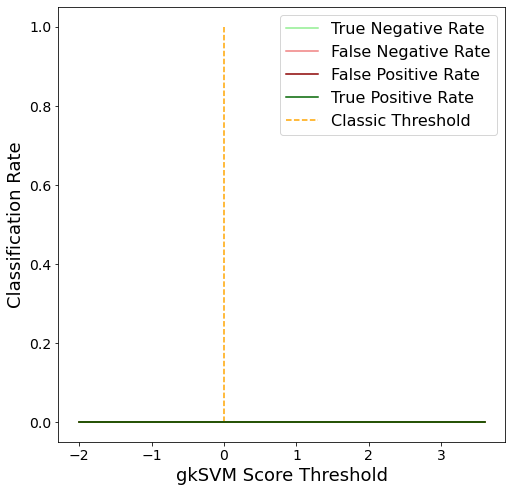

In [221]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
plt.plot(threshs, tns/nb_negs, color="lightgreen", label="True Negative Rate")
plt.plot(threshs, fns/nb_pos, color="lightcoral", label="False Negative Rate")
plt.plot(threshs, fps/nb_negs, color="darkred", label="False Positive Rate")
plt.plot(threshs, tps/nb_pos, color="darkgreen", label="True Positive Rate")
plt.vlines(0, 0, 1, color="orange", linestyle="dashed", label="Classic Threshold")
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("gkSVM Score Threshold")
plt.ylabel("Classification Rate")

## gkmexplain Interpretation

In [248]:
# Read in scores
explain_file = os.path.join(OUTDIR, "2021_OLS_Library_Heldout.explanations.txt")
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explain_file)
]

#read in the fasta files and one-hot encode
fasta_file = "../data/2021_OLS_Library/fasta/0.09-0.4_X-hold-out_fasta.fa"
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fasta_file))
              if i%2==1]
fasta_ids = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(fasta_file))
              if i%2==0]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

In [ ]:
val_df.loc[fa]

S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6


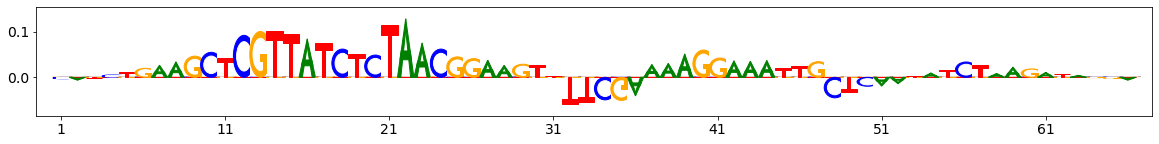

S1-G1F-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6


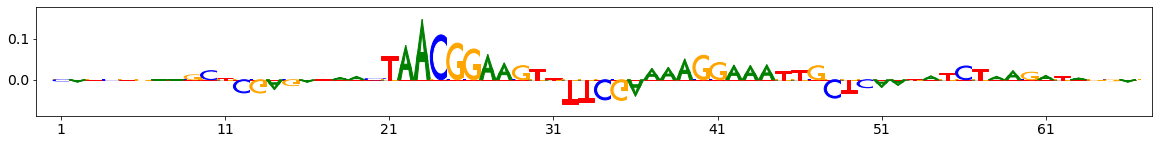

S1-G1R-S2-E1F-S3-E2F-S4-G2F-S5-G3F-S6


In [ ]:
for i in range(9):
    print(fasta_ids[i])
    viz_sequence.plot_weights(impscores[i], subticks_frequency=10)
    imp_score_each_pos = np.sum(impscores[i],axis=-1)
    imp_score_sign_each_pos = np.sign(imp_score_each_pos)

# Analysis of "Ambiguous" Enhancers
 - Scatterplot of correlation with activity, again colored by microscope function

In [599]:
ambiguous_df = held_out_df[~microscope_mask]
data = ambiguous_df

## Scatterplot with Activity 

<AxesSubplot:xlabel='ACTIVITY_SUMRNA_NUMDNA', ylabel='gkSVM_score'>

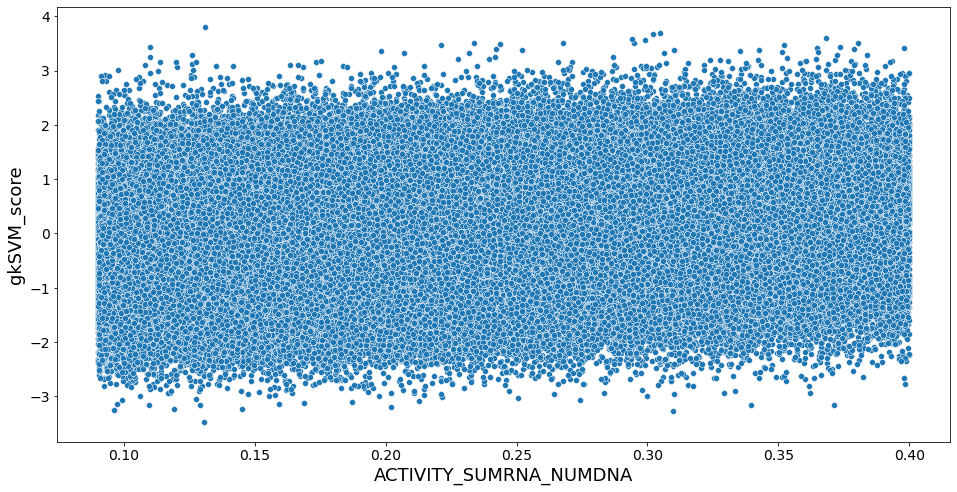

In [600]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
sns.scatterplot(data=ambiguous_df, x="ACTIVITY_SUMRNA_NUMDNA", y="gkSVM_score", ax=ax)

In [601]:
no_na = (~ambiguous_df["ACTIVITY_SUMRNA_NUMDNA"].isna())

In [602]:
stats.pearsonr(ambiguous_df[no_na]["ACTIVITY_SUMRNA_NUMDNA"], ambiguous_df[no_na]["gkSVM_score"])

(0.21259503737187, 0.0)

# Analysis of Khoueiry Enhancers
 - Scatterplot with length
 - Interpretation of salient features using gkmexplain

In [565]:
data = test1_df
data = test1_df[(test1_df["Type"] == "full")]
data_tiled = test1_df[~(test1_df["Type"] == "full")]
data_tiled["Type"] = data_tiled["Type"].astype(int)

<ipython-input-565-ba8d89a03810>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiled["Type"] = data_tiled["Type"].astype(int)


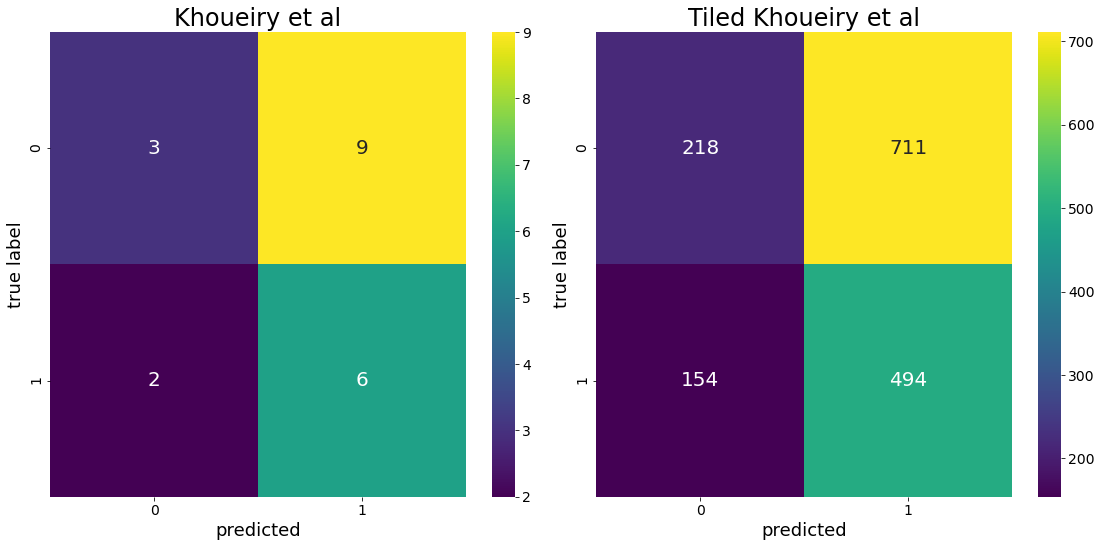

In [566]:
fig, ax = plt.subplots(1,2,figsize=(16,8))

rc = {"font.size": 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(data["label"], data["gkSVM_preds"]), annot=True, fmt='d', cmap='viridis', ax=ax[0])
    ax[0].set_xlabel('predicted')
    ax[0].set_ylabel('true label')
    ax[0].set_title('Khoueiry et al')
    plt.tight_layout();

rc = {"font.size": 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(data_tiled["label"], data_tiled["gkSVM_preds"]), annot=True, fmt='d', cmap='viridis', ax=ax[1])
    ax[1].set_xlabel('predicted')
    ax[1].set_ylabel('true label')
    ax[1].set_title('Tiled Khoueiry et al')
    plt.tight_layout();

In [459]:
import matplotlib.patches as mpatches

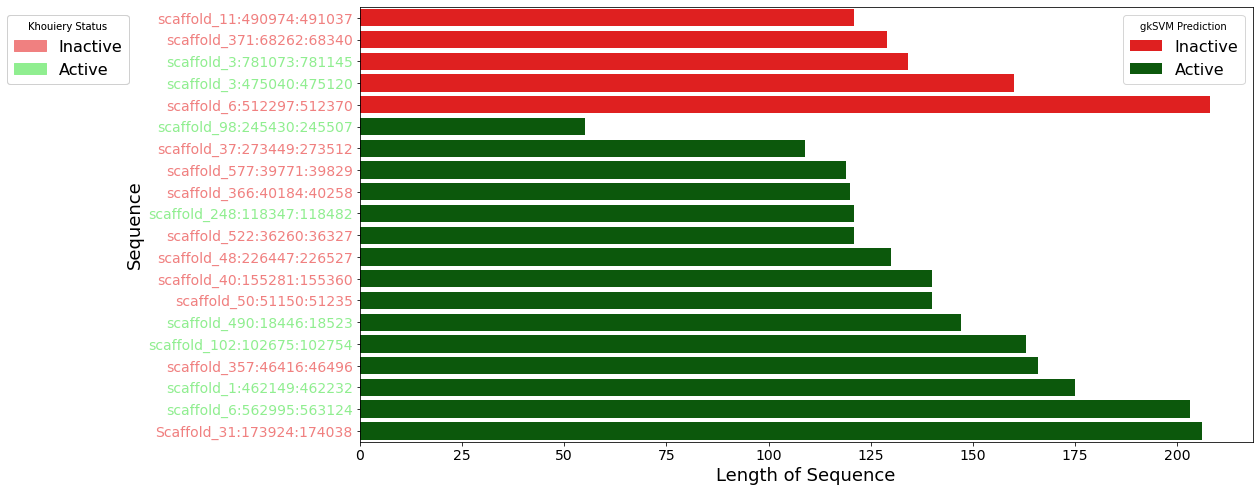

In [497]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
data_plot = data.reset_index().sort_values(["gkSVM_preds", "Sequence_len"])
data_plot["gkSVM_preds"] = data_plot["gkSVM_preds"].replace({0:"Inactive", 1:"Active"})
sns.barplot(data=data_plot, y="NAME", x="Sequence_len", hue="gkSVM_preds", palette=["red", "darkgreen"], orient="h", dodge=False, ax=ax)
for label in ax.get_yticklabels():
    if data.loc[label.get_text()]["label"] == 1:
        label.set_color("lightgreen")
    elif data.loc[label.get_text()]["label"] == 0:
        label.set_color("lightcoral")
ax.set_xlabel("Length of Sequence")
ax.set_ylabel("Sequence")
legend1 = ax.legend(title='gkSVM Prediction', fontsize=16);
red_patch = mpatches.Patch(color='lightgreen', label='Active')
green_patch = mpatches.Patch(color='lightcoral', label='Inactive')
legend2 = plt.legend(title='Khouiery Status', handles=[green_patch, red_patch], bbox_to_anchor=(-0.25,1))
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2);

## Scatterplot with length


<AxesSubplot:xlabel='Sequence_len', ylabel='gkSVM_score'>

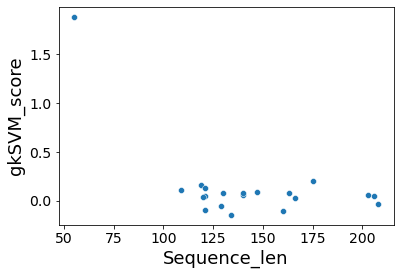

In [228]:
sns.scatterplot(data=test1_df, x="Sequence_len", y="gkSVM_score")

## Stripplot along tile

Text(0.5, 0, 'Start Position')

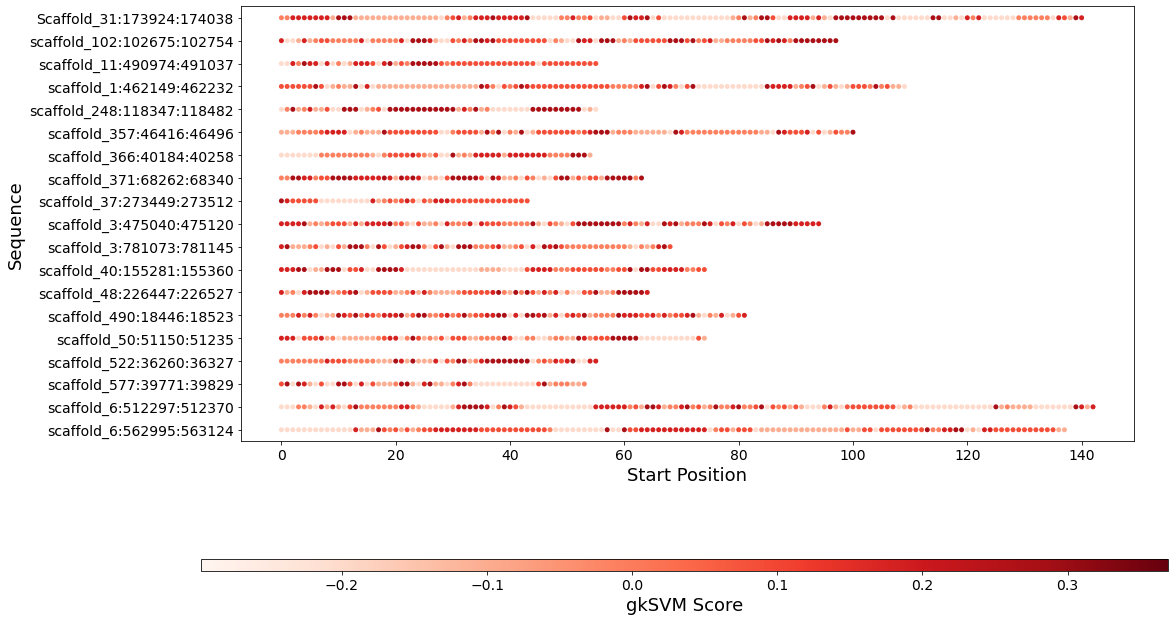

In [567]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
cmap = mpl.cm.Reds
sns.stripplot(data=data_tiled, x="Type", y="level_0", hue="gkSVM_score", orient="h", jitter=False, ax=ax, palette=sns.color_palette("Reds"))
ax.get_legend().set_visible(False)
cax = fig.add_axes([0.09, -0.1, 0.84, 0.02])
norm = mpl.colors.Normalize(vmin=data_tiled["gkSVM_score"].min(), vmax=data_tiled["gkSVM_score"].max())
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label("gkSVM Score")
ax.set_ylabel("Sequence")
ax.set_xlabel("Start Position")

## Interpetation of salient features using gkmexplain

In [474]:
# Read in scores
explain_file = os.path.join(OUTDIR, "2010_Khoueiry_CellPress.explanations.txt")
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explain_file)
]

#read in the fasta files and one-hot encode
fasta_file = "../data/2010_Khoueiry_CellPress/fasta/X_fasta-all.fa"
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fasta_file))
              if i%2==1]
fasta_ids = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(fasta_file))
              if i%2==0]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

<ipython-input-474-3192c62e5417>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  onehot_data = np.array([one_hot_encode_along_channel_axis(x)


In [475]:
viz_df = test1_df.loc[fasta_ids].reset_index()

[-0.555067 'FN']
[-0.591061 'FN']
[-0.718323 'FN']
[-0.677472 'FN']
[1.21354 'TP']
[-0.602657 'FN']
[-0.613365 'FN']
[-0.570865 'FN']


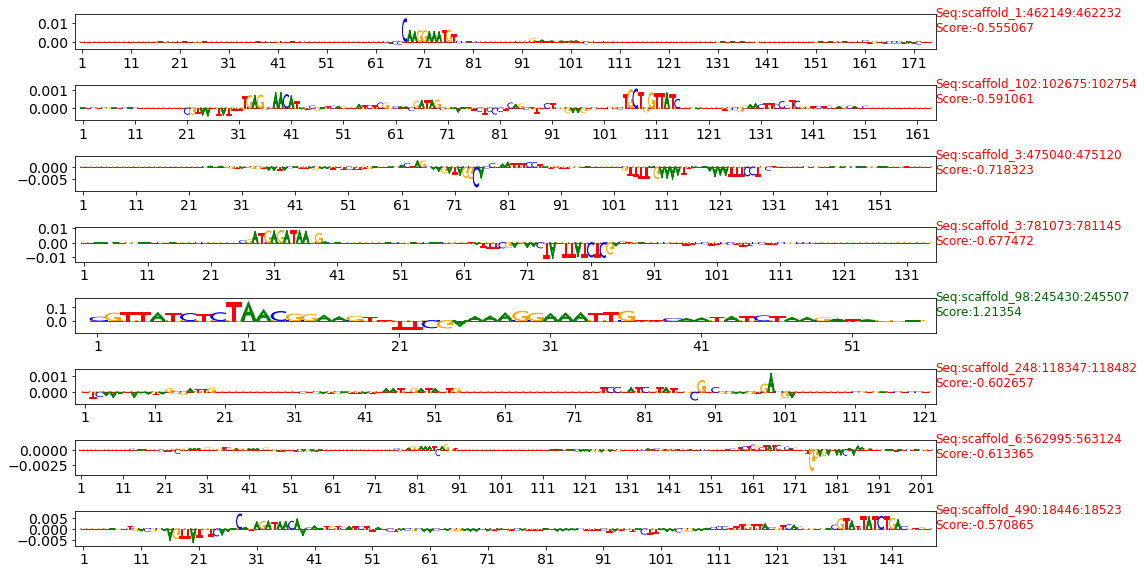

In [476]:
j=0
pos_viz_df = viz_df[viz_df["label"] == 1]
fig, ax = plt.subplots(len(pos_viz_df), 1, figsize=(16,8))
for i in pos_viz_df.index:
    print(pos_viz_df.loc[i][["gkSVM_score", "gkSVM_classification"]].values)
    viz_sequence.plot_weights_given_ax(ax[j], impscores[i], subticks_frequency=10)
    imp_score_each_pos = np.sum(impscores[i],axis=-1)
    imp_score_sign_each_pos = np.sign(imp_score_each_pos)
    med = (ax[j].get_ylim()[0] + ax[j].get_ylim()[1])/2
    if pos_viz_df.loc[i]["gkSVM_classification"] in ["FN", "FP"]:
        ax[j].annotate("Seq:{0}\nScore:{1}".format(pos_viz_df.loc[i]["NAME"], pos_viz_df.loc[i]["gkSVM_score"]), (ax[j].get_xlim()[1]+0.01, med), color="red", fontsize=12)
    else:
        ax[j].annotate("Seq:{0}\nScore:{1}".format(pos_viz_df.loc[i]["NAME"], pos_viz_df.loc[i]["gkSVM_score"]), (ax[j].get_xlim()[1]+0.01, med), color="darkgreen", fontsize=12)
    j+=1
plt.tight_layout()

[-0.630417 'TN']
[-0.51043 'TN']
[-0.672204 'TN']
[-0.614722 'TN']
[-0.755911 'TN']
[-0.620072 'TN']
[-0.58505 'TN']
[-0.670271 'TN']
[-0.598918 'TN']
[-0.561676 'TN']
[-0.588151 'TN']
[-0.532811 'TN']


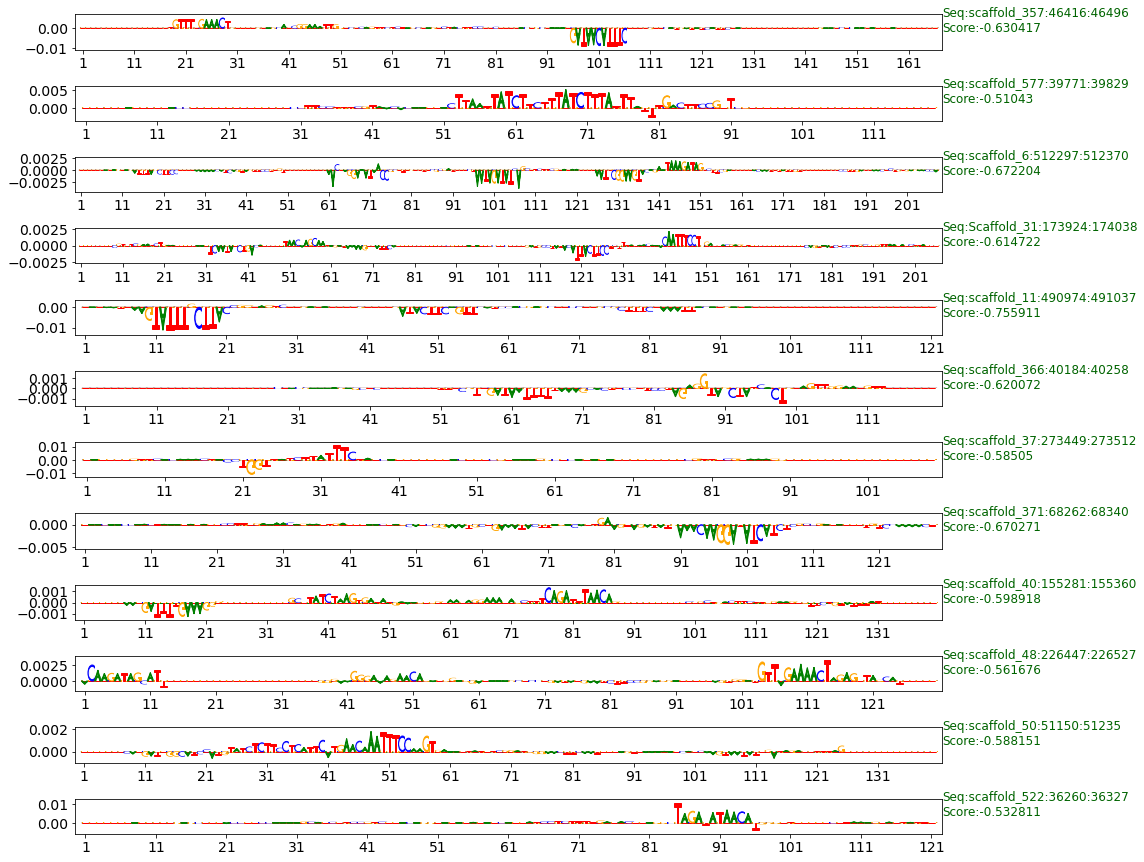

In [477]:
j=0
neg_viz_df = viz_df[viz_df["label"] == 0]
fig, ax = plt.subplots(len(neg_viz_df), 1, figsize=(16,12))
for i in neg_viz_df.index:
    print(neg_viz_df.loc[i][["gkSVM_score", "gkSVM_classification"]].values)
    viz_sequence.plot_weights_given_ax(ax[j], impscores[i], subticks_frequency=10)
    imp_score_each_neg = np.sum(impscores[i],axis=-1)
    imp_score_sign_each_neg = np.sign(imp_score_each_neg)
    med = (ax[j].get_ylim()[0] + ax[j].get_ylim()[1])/2
    if neg_viz_df.loc[i]["gkSVM_classification"] in ["FN", "FP"]:
        ax[j].annotate("Seq:{0}\nScore:{1}".format(neg_viz_df.loc[i]["NAME"], neg_viz_df.loc[i]["gkSVM_score"]), (ax[j].get_xlim()[1]+0.01, med), color="red", fontsize=12)
    else:
        ax[j].annotate("Seq:{0}\nScore:{1}".format(neg_viz_df.loc[i]["NAME"], neg_viz_df.loc[i]["gkSVM_score"]), (ax[j].get_xlim()[1]+0.01, med), color="darkgreen", fontsize=12)
    j+=1
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
cmap = mpl.cm.Reds
sns.stripplot(data=data_tiled, x="Type", y="level_0", hue="gkSVM_score", orient="h", jitter=False, ax=ax, palette=sns.color_palette("Reds"))
ax.get_legend().remove()
cax = fig.add_axes([0.09, -0.1, 0.84, 0.02])
norm = mpl.colors.Normalize(vmin=data_tiled["gkSVM_score"].min(), vmax=data_tiled["gkSVM_score"].max())
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label("gkSVM Score")

# Analysis of Tested GATA ETS Clusters
 - Scatterplot with length
 - Interpretation of salient features using gkmexplain

In [568]:
data = test2_df
data = test2_df[(test2_df["Type"] == "full")]
data_tiled = test2_df[~(test2_df["Type"] == "full")]
data_tiled["Type"] = data_tiled["Type"].astype(int)

<ipython-input-568-3a16c4a1c946>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tiled["Type"] = data_tiled["Type"].astype(int)


In [569]:
data["level_0"].value_counts()

Otxa-WTg5           1
nc3                 1
Negative_control    1
Otxa-WTg2           1
Otxa-WTg1           1
Otxa-WTg3           1
nc2                 1
nc5                 1
nc4                 1
Name: level_0, dtype: int64

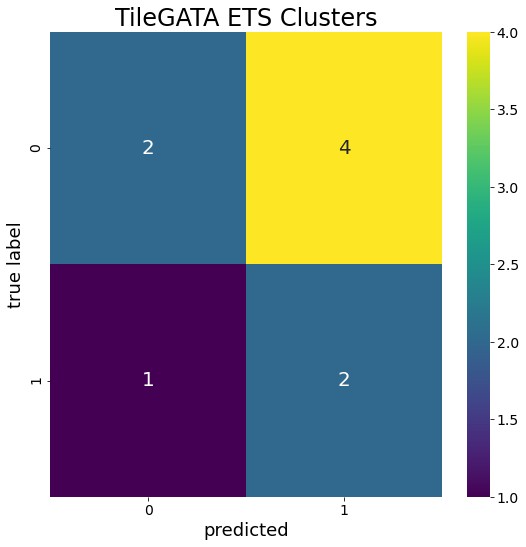

In [570]:
fig, ax = plt.subplots(1,1,figsize=(8,8))

rc = {"font.size": 20}
with plt.rc_context(rc):
    sns.heatmap(confusion_matrix(data["label"], data["gkSVM_preds"]), annot=True, fmt='d', cmap='viridis', ax=ax)
    ax.set_xlabel('predicted')
    ax.set_ylabel('true label')
    ax.set_title('TileGATA ETS Clusters')
    plt.tight_layout();

In [571]:
data

,level_0,Type,index,Sequence,Functional,label,sequence_len,gkSVM_score,gkSVM_preds,gkSVM_classification
68,Negative_control,full,4,CAGGAAATTCCCGTTATCTATCCATCGCTATACTTCGTGTAGTTAT...,No,0,133,-0.056370,0,TN
97,Otxa-WTg1,full,0,CGTGGTACTAGAAATTTTATCACTGTCGTGGTACCGGAAAATTTAT...,Yes,1,93,0.104602,1,TP
131,Otxa-WTg2,full,1,ATTATCATTACCTTATTATCAAATGTGCAAGAGGGACGCGGAAGTA...,Yes,1,98,-0.070874,0,FN
132,Otxa-WTg3,full,2,CCTATATCTATAATAACAGTCGGAAATTGCCGGAAAATAATAAAAT...,No,0,54,0.041103,1,FP
184,Otxa-WTg5,full,3,CATAGATAGCAACAATGCCATCTTATCTACGTAACTAGGAAACATA...,Yes,1,116,0.070599,1,TP
193,nc2,full,5,TTATTATCGGACTCAAAGTAGCAAACGGAAATCATGCGTGATGAAC...,No,0,73,0.056837,1,FP
236,nc3,full,6,GTTTGGATAGAGCGCAAGGTTTATCACAGCAGGATATATAAAAAAC...,No,0,107,0.092482,1,FP
240,nc4,full,7,AAATTATCAACGTACAGAAATTATCTTGGATTGAAATGCAAGCGTC...,No,0,68,-0.028925,0,TN
257,nc5,full,8,TTATTATCGTTTTTTAATATATTTATCAGGTTTCTCTCGTTTCCTG...,No,0,81,0.072367,1,FP


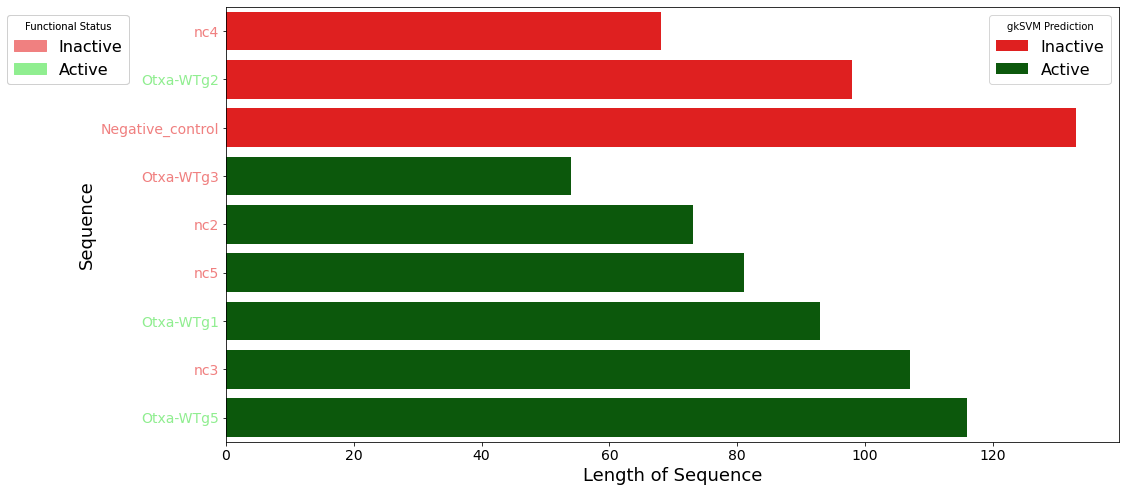

In [572]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
data_plot = data.sort_values(["gkSVM_preds", "sequence_len"])
data_plot["gkSVM_preds"] = data_plot["gkSVM_preds"].replace({0:"Inactive", 1:"Active"})
sns.barplot(data=data_plot, y="level_0", x="sequence_len", hue="gkSVM_preds", palette=["red", "darkgreen"], orient="h", dodge=False, ax=ax)
for label in ax.get_yticklabels():
    if data.set_index("level_0").loc[label.get_text()]["label"] == 1:
        label.set_color("lightgreen")
    elif data.set_index("level_0").loc[label.get_text()]["label"] == 0:
        label.set_color("lightcoral")
ax.set_xlabel("Length of Sequence")
ax.set_ylabel("Sequence")
legend1 = ax.legend(title='gkSVM Prediction', fontsize=16);
red_patch = mpatches.Patch(color='lightgreen', label='Active')
green_patch = mpatches.Patch(color='lightcoral', label='Inactive')
legend2 = plt.legend(title='Functional Status', handles=[green_patch, red_patch], bbox_to_anchor=(-0.1,1))
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2);

Text(0, 0.5, 'Sequence')

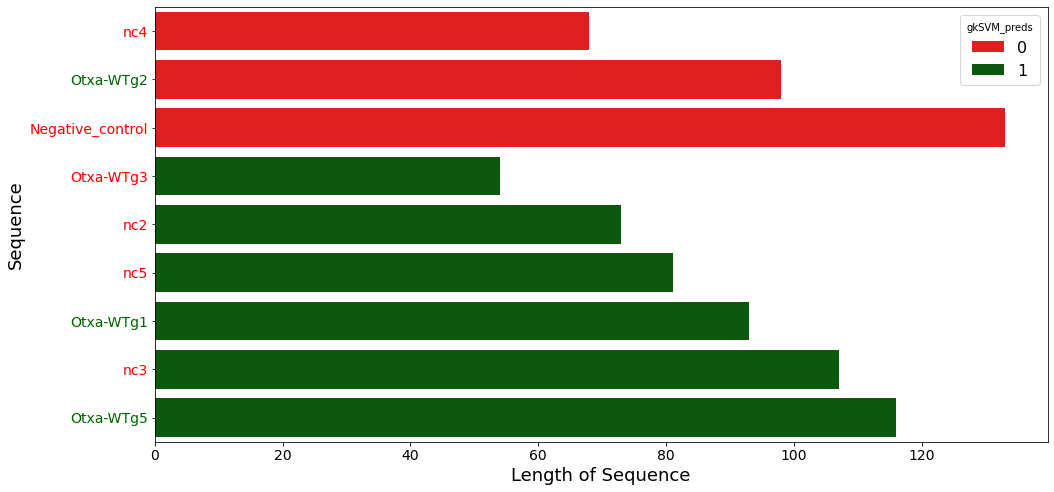

In [573]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
sns.barplot(data=data.sort_values(["gkSVM_preds", "sequence_len"]), y="level_0", x="sequence_len", hue="gkSVM_preds", palette=["red", "darkgreen"], orient="h", dodge=False, ax=ax)
for label in ax.get_yticklabels():
    if data.set_index("level_0").loc[label.get_text()]["label"] == 1:
        label.set_color("darkgreen")
    elif data.set_index("level_0").loc[label.get_text()]["label"] == 0:
        label.set_color("red")
ax.set_xlabel("Length of Sequence")
ax.set_ylabel("Sequence")

## Stripplot along tile

Text(0.5, 0, 'Start Position')

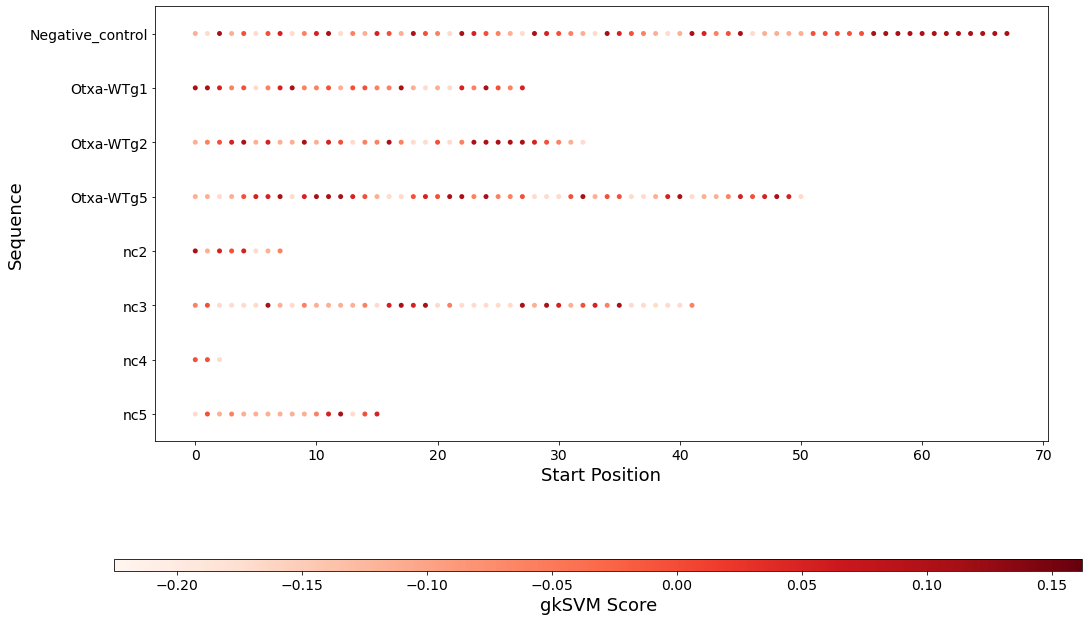

In [574]:
fig, ax = plt.subplots(1, 1, figsize=(16,8))
cmap = mpl.cm.Reds
sns.stripplot(data=data_tiled, x="Type", y="level_0", hue="gkSVM_score", orient="h", jitter=False, ax=ax, palette=sns.color_palette("Reds"))
ax.get_legend().remove()
cax = fig.add_axes([0.09, -0.1, 0.84, 0.02])
norm = mpl.colors.Normalize(vmin=data_tiled["gkSVM_score"].min(), vmax=data_tiled["gkSVM_score"].max())
cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, orientation='horizontal')
cb.set_label("gkSVM Score")
ax.set_ylabel("Sequence")
ax.set_xlabel("Start Position")

## Interpetation of salient features using gkmexplain

In [512]:
# Read in scores
explain_file = os.path.join(OUTDIR, "2021_GATA_ETS.explanations.txt")
impscores = [
    np.array( [[float(z) for z in y.split(",")] for y in x.rstrip().split("\t")[2].split(";")])
    for x in open(explain_file)
]

#read in the fasta files and one-hot encode
fasta_file = "../data/2021_GATA_ETS_clusters/fasta/X_fasta-all.fa"
fasta_seqs = [x.rstrip() for (i,x) in enumerate(open(fasta_file))
              if i%2==1]
fasta_ids = [x.rstrip().replace(">", "") for (i,x) in enumerate(open(fasta_file))
              if i%2==0]
onehot_data = np.array([one_hot_encode_along_channel_axis(x)
                         for x in fasta_seqs])

<ipython-input-512-27bad8216309>:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  onehot_data = np.array([one_hot_encode_along_channel_axis(x)


In [513]:
fasta_ids = [ID.split(":")[0] for ID in fasta_ids]

In [514]:
viz_df = data.set_index("level_0").loc[fasta_ids].reset_index()

In [515]:
viz_df

,level_0,Type,index,Sequence,Functional,label,sequence_len,gkSVM_score,gkSVM_preds,gkSVM_classification
0,Otxa-WTg1,full,0,CGTGGTACTAGAAATTTTATCACTGTCGTGGTACCGGAAAATTTAT...,Yes,1,93,-0.560711,0,FN
1,Otxa-WTg2,full,1,ATTATCATTACCTTATTATCAAATGTGCAAGAGGGACGCGGAAGTA...,Yes,1,98,-0.741102,0,FN
2,Otxa-WTg3,full,2,CCTATATCTATAATAACAGTCGGAAATTGCCGGAAAATAATAAAAT...,No,0,54,-0.604403,0,TN
3,Otxa-WTg5,full,3,CATAGATAGCAACAATGCCATCTTATCTACGTAACTAGGAAACATA...,Yes,1,116,-0.593502,0,FN
4,Negative_control,full,4,CAGGAAATTCCCGTTATCTATCCATCGCTATACTTCGTGTAGTTAT...,No,0,133,-0.689763,0,TN
5,nc2,full,5,TTATTATCGGACTCAAAGTAGCAAACGGAAATCATGCGTGATGAAC...,No,0,73,-0.615557,0,TN
6,nc3,full,6,GTTTGGATAGAGCGCAAGGTTTATCACAGCAGGATATATAAAAAAC...,No,0,107,-0.519538,0,TN
7,nc4,full,7,AAATTATCAACGTACAGAAATTATCTTGGATTGAAATGCAAGCGTC...,No,0,68,-0.699082,0,TN
8,nc5,full,8,TTATTATCGTTTTTTAATATATTTATCAGGTTTCTCTCGTTTCCTG...,No,0,81,-0.569410,0,TN


[-0.560711 'FN']
[-0.741102 'FN']
[-0.604403 'TN']
[-0.593502 'FN']
[-0.689763 'TN']
[-0.615557 'TN']
[-0.519538 'TN']
[-0.699082 'TN']
[-0.56941 'TN']


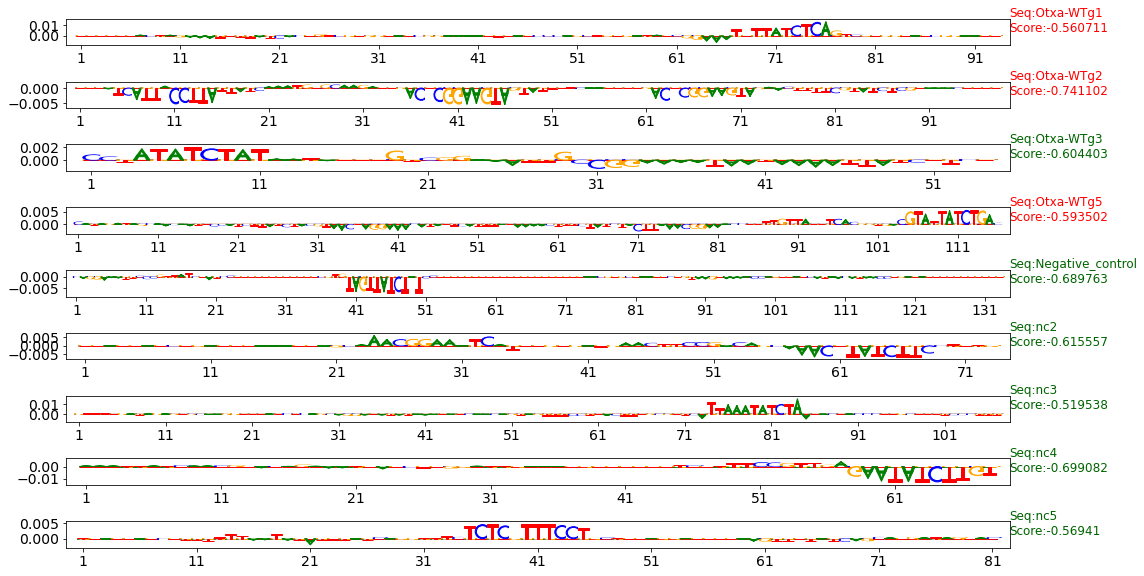

In [516]:
j=0
fig, ax = plt.subplots(len(viz_df), 1, figsize=(16,8))
for i in viz_df.index:
    print(viz_df.loc[i][["gkSVM_score", "gkSVM_classification"]].values)
    viz_sequence.plot_weights_given_ax(ax[j], impscores[i], subticks_frequency=10)
    imp_score_each_pos = np.sum(impscores[i],axis=-1)
    imp_score_sign_each_pos = np.sign(imp_score_each_pos)
    med = (ax[j].get_ylim()[0] + ax[j].get_ylim()[1])/2
    if viz_df.loc[i]["gkSVM_classification"] in ["FN", "FP"]:
        ax[j].annotate("Seq:{0}\nScore:{1}".format(viz_df.loc[i]["level_0"], viz_df.loc[i]["gkSVM_score"]), (ax[j].get_xlim()[1]+0.01, med), color="red", fontsize=12)
    else:
        ax[j].annotate("Seq:{0}\nScore:{1}".format(viz_df.loc[i]["level_0"], viz_df.loc[i]["gkSVM_score"]), (ax[j].get_xlim()[1]+0.01, med), color="darkgreen", fontsize=12)
    j+=1
plt.tight_layout()

# Scratch

# References